In [58]:
import pandas as pd
from data_loader import data_load_and_split

big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, trimmed_firstMeas_train, trimmed_secondMeas_train, trimmed_firstMeas_test, trimmed_secondMeas_test = data_load_and_split()

In [59]:
trimmed_firstMeas_train.info(verbose = True)
trimmed_firstMeas_train.head()

trimmed_secondMeas_train.info(verbose = True)

train1 = trimmed_firstMeas_train
train1 = train1.drop("Unnamed: 0", axis = 1)

train2 = trimmed_secondMeas_train
train2 = train2.drop("Unnamed: 0", axis = 1)

<class 'pandas.core.frame.DataFrame'>
Index: 9725 entries, 5504 to 7408
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               9725 non-null   int64  
 1   PLOT                     9725 non-null   int64  
 2   LAT                      9725 non-null   float64
 3   LON                      9725 non-null   float64
 4   ELEV                     9725 non-null   float64
 5   COUNTYCD                 9725 non-null   int64  
 6   UNITCD                   9725 non-null   int64  
 7   PLT_CN                   9725 non-null   int64  
 8   CN                       9725 non-null   int64  
 9   PREV_TRE_CN              0 non-null      float64
 10  UNIQUE_PLOT_ID           9725 non-null   object 
 11  INVYR                    9725 non-null   int64  
 12  MEASYEAR                 9725 non-null   int64  
 13  MEASMON                  9725 non-null   int64  
 14  MEASDAY                  9

##### The following section was to satisfy my own curiosity about species representation in the dataset:

In [60]:
train1.SPGRPCD.value_counts()

SPGRPCD
10    2657
12    2278
21    2139
11     910
18     625
24     369
19     360
13     103
22      81
44      67
48      49
15      38
47      30
46      18
45       1
Name: count, dtype: int64

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

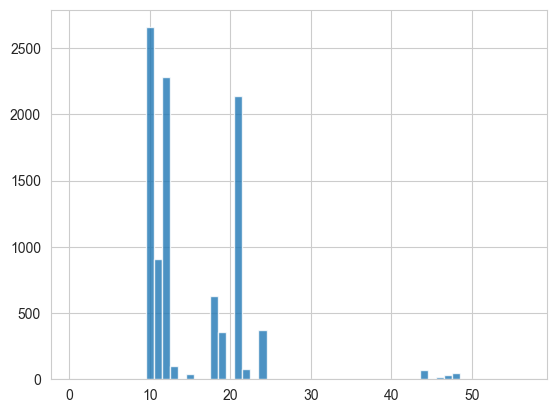

In [62]:
plt.hist(train1["SPGRPCD"], range = [0.5,56.5], bins = 56, alpha = .8)
plt.show()

Codes 1-24 are softwoods, 25-48 are hardwoods, 51-54 are tropical/subtropical, and 55-56 are "urban" (whatever that means). Full details in Appendix E of the FIA user guide. So the vast majority of our sample are softwoods of various types. It might make sense to break those apart further eventually.

## Merging tables

In [67]:
combined_train = train1.merge(train2, left_on = "CN", right_on = "PREV_TRE_CN", suffixes = ("_pre_burn", "_post_burn"))
combined_train.dropna(axis = 1, how = "all", inplace = True)

# Checking the merge and removing redundant identifiers
assert((combined_train["CN_pre_burn"] == combined_train["PREV_TRE_CN_post_burn"]).all())
combined_train.drop("PREV_TRE_CN_post_burn", axis = 1, inplace = True)
combined_train.rename(columns={"CN_pre_burn": "CN"}, inplace = True)

# Cleaning up redundant columns
stable_features = ["PLOT", "LAT", "LON", "ELEV", "COUNTYCD", "UNITCD", "TREE", "SUBP", "UNIQUE_PLOT_ID"]
for col in stable_features:
    if bool((combined_train[col + "_pre_burn"] == combined_train[col + "_post_burn"]).all()) == False:
        print(f"Merge issue! {col} doesn't match!")
    else: 
        combined_train.drop(col+"_post_burn", axis = 1, inplace = True)
        combined_train.rename(columns={col+"_pre_burn": col}, inplace = True)

# Simplifying fire column names
for num in ["1","2","3"]:
    for col in ["INCIDENT", "FIREYEAR", "AREA", "PERIM"]:
        combined_train.rename(columns={col+num+"_post_burn": col+num}, inplace = True)


combined_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9725 entries, 0 to 9724
Data columns (total 93 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PLOT                               9725 non-null   int64  
 1   LAT                                9725 non-null   float64
 2   LON                                9725 non-null   float64
 3   ELEV                               9725 non-null   float64
 4   COUNTYCD                           9725 non-null   int64  
 5   UNITCD                             9725 non-null   int64  
 6   PLT_CN_pre_burn                    9725 non-null   int64  
 7   CN                                 9725 non-null   int64  
 8   UNIQUE_PLOT_ID                     9725 non-null   object 
 9   INVYR_pre_burn                     9725 non-null   int64  
 10  MEASYEAR_pre_burn                  9725 non-null   int64  
 11  MEASMON_pre_burn                   9725 non-null   int64

## On to the data science!

In [ ]:
combined_train["YRS_SINCE_BURN"] = combined_train["MEASYEAR_post_burn"] - combined_train["FIREYEAR3"]
#combined_train["NUM_BURNS"] =

indicator_features = ["CN", "ELEV", "YRS_SINCE_BURN"] #unfinished
outcome_features = ["CONDID_post_burn", "CULL_post_burn"] 
mini_train = combined_train[indicator_features + outcome_features]

mini_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9725 entries, 0 to 9724
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CN                9725 non-null   int64  
 1   ELEV              9725 non-null   float64
 2   YRS_SINCE_BURN    106 non-null    float64
 3   CONDID_post_burn  9725 non-null   int64  
 4   CULL_post_burn    6299 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 380.0 KB
